<a href="https://colab.research.google.com/github/Amir-D-Shadow/Google-Colab/blob/main/alpha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy  as np
from matplotlib import pyplot as plt

In [ ]:
x = tf.constant(value = np.random.randn(10,38,38,85))
y = K.sum(x)
K.eval(y)
type(K.eval(K.shape(x)[0]).item())

int

In [88]:
def left_x_pred_x_true_pair_assign_func(input_tensor,value_tensor,in_pos,val_pos):

  input_tensor = input_tensor.numpy()
  val = value_tensor.numpy()

  input_tensor[:,:,:,in_pos] = val[:,:,:,val_pos]

  return input_tensor

def left_y_pred left_y_true_assign_func(input_tensor,value_tensor,in_pos,val_pos):

  input_tensor = input_tensor.numpy()
  val = value_tensor.numpy()

  input_tensor

In [20]:
class alpha_loss(tf.keras.losses.Loss):

  def __init__(self,gamma = 2):

    super(alpha_loss,self).__init__()

    self.gamma = gamma

  def call(self,y_true,y_pred):

    #get prob
    prob_true = y_true[:,:,:,0]
    prob_pred = y_pred[:,:,:,0]

    #get class
    class_true = y_true[:,:,:,5:]
    class_pred = y_pred[:,:,:,5:]

    #****************** Focal loss ******************

    #get batch size
    m = K.cast(K.shape(y_pred)[0],K.dtype(y_pred))

    #clip the prediction
    prob_pred = K.clip(prob_pred,min_value = 0.0, max_value = 1.0)
    class_pred = K.clip(class_pred,min_value = 0.0, max_value = 1.0)

    #prob focal loss
    loss_tensor =  - ( (1 - prob_pred)**self.gamma ) * prob_true * tf.math.log( prob_pred + 1e-18 ) - ( prob_pred ** self.gamma ) * ( 1 - prob_true ) * tf.math.log( 1 - prob_pred + 1e-18 )
    prob_focal_loss = K.sum(loss_tensor)/ m

    #class focal loss
    loss_tensor =  - ( (1 - class_pred)**self.gamma ) * class_true * tf.math.log( class_pred + 1e-18 ) - ( class_pred ** self.gamma) * ( 1 - class_true ) * tf.math.log( 1 - class_pred + 1e-18 )
    class_focal_loss = K.sum(loss_tensor) / m


    #****************** Focal loss ******************

    #get reg left -- (x,y)
    reg_left_true = y_true[:,:,:,1:3] 
    reg_left_pred = y_pred[:,:,:,1:3]

    #get reg center -- (x,y)
    reg_center_true = y_true[:,:,:,3:5] 
    reg_center_pred = y_pred[:,:,:,3:5]

    #calculate width x height of anchor box
    reg_wh_true = (reg_center_true[:,:,:,:] - reg_left_true[:,:,:,:])*2
    reg_wh_pred = (reg_center_pred[:,:,:,:] - reg_left_pred[:,:,:,:])*2 

    #calculate reg right
    reg_right_true = reg_left_true[:,:,:,:] + reg_wh_true[:,:,:,:]
    reg_right_pred = reg_left_pred[:,:,:,:] + reg_wh_pred[:,:,:,:]

    #****************** DIOU loss ******************

    #----------------------------------------------------------------------
    #calculate IOU  

    #calculate intersection left
    reg_left_intersection = tf.math.maximum(reg_left_pred,reg_left_true)

    #calculate intersection right
    reg_right_intersection = tf.math.minimum(reg_right_pred,reg_right_true)

    #calibrate
    #reg_right_intersection = tf.where((reg_left_intersection>reg_right_intersection),reg_left_intersection,reg_right_intersection) #-- same meaning
    reg_right_intersection = tf.math.maximum(reg_left_intersection,reg_right_intersection) #-- same meaning

    #intersection width height
    intersection_wh = reg_right_intersection[:,:,:,:] - reg_left_intersection[:,:,:,:]

    #intersection area
    intersection_area = intersection_wh[:,:,:,0] * intersection_wh[:,:,:,1]

    #union area
    true_area = reg_wh_true[:,:,:,0] * reg_wh_true[:,:,:,1]
    pred_area = reg_wh_pred[:,:,:,0] * reg_wh_pred[:,:,:,1]

    union_area = true_area[:,:,:] + pred_area[:,:,:] - intersection_area[:,:,:]

    #calculate iou 
    iou_val = intersection_area[:,:,:] / union_area[:,:,:]
    #----------------------------------------------------------------------

    #outermost anchor box
    outermost_left = tf.math.minimum(reg_left_pred,reg_left_true)
    outermost_right = tf.math.maximum(reg_right_pred,reg_right_true)

    #outermost distance
    distance_outermost =  K.sum( K.square(outermost_right[:,:,:,:] - outermost_left[:,:,:,:]) ,axis=-1) 
   
    #center distance
    distance_center =  K.sum( K.square(reg_center_true[:,:,:,:] - reg_center_pred[:,:,:,:]) ,axis=-1) 
    #----------------------------------------------------------------------

    #calculate DIOU
    loss_tensor = 1 - (iou_val[:,:,:] - distance_center[:,:,:]/distance_outermost[:,:,:] )
    reg_loss = K.sum(loss_tensor)

    #****************** DIOU loss ******************

    #calculate loss
    loss = prob_focal_loss + class_focal_loss + reg_loss

    return loss

In [29]:
np.random.seed(1)
y_true = tf.constant(value = np.random.randn(10,38,38,85),dtype=np.float64)
data = tf.constant(value= np.random.randn(10,40,40,3),dtype=np.float64)

x = tf.keras.layers.Input(shape =(40,40,3))

k1 = tf.keras.layers.BatchNormalization(axis=-1)(x)
h1 = tf.keras.layers.Conv2D(256,3,1,"valid",data_format="channels_last")(k1)
h2 = tf.keras.layers.BatchNormalization(axis=-1)(h1)
h3 = tf.keras.layers.LeakyReLU()(h2)
drop_h = tf.keras.layers.SpatialDropout2D(0.5)(h3)
h4 = tf.keras.layers.Conv2D(256,3,1,"same",data_format="channels_last")(drop_h)
h5 = tf.keras.layers.BatchNormalization(axis=-1)(h4)
h6 = tf.keras.layers.LeakyReLU()(h5)
k2 = tf.keras.layers.Conv2D(85,3,1,"same",data_format="channels_last")(h6)

model = tf.keras.Model(inputs=x,outputs=k2)

model.compile(optimizer="adam",loss=alpha_loss())

b = model.fit(data,y_true,epochs=50)


Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 677722.3125
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 332819.1562
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 186419.0625
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 117206.4531
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 88266.4531
Epoch 6/50
1/1 [==============================] - 2s 2s/step - loss: 78416.6094
Epoch 7/50
1/1 [==============================] - 2s 2s/step - loss: 68332.7031
Epoch 8/50
1/1 [==============================] - 2s 2s/step - loss: 62211.5859
Epoch 9/50
1/1 [==============================] - 2s 2s/step - loss: 57303.8125
Epoch 10/50
1/1 [==============================] - 2s 2s/step - loss: 54810.9609
Epoch 11/50
1/1 [==============================] - 2s 2s/step - loss: 57438.1641
Epoch 12/50
1/1 [==============================] - 2s 2s/step - loss: 51555.6211
Epoch 13/50
1/1 [================

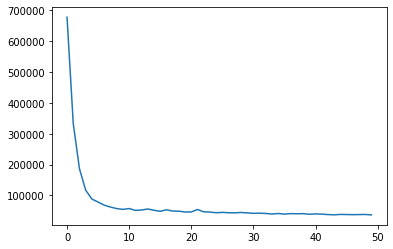

In [30]:
plt.plot(b.history["loss"])